In [2]:
import os
import ngene as ng
import numpy as np
import pylab as plt
from glob import glob
import tensorflow as tf
from random import choice,shuffle
import ccgpack as ccg
import cv2 as cv
from sklearn.metrics import confusion_matrix
from scipy.interpolate import interp1d
from scipy.stats import ttest_ind

#import healpy as hp

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          #title='Confusion matrix',
                          cmap=plt.cm.Purples):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.gca().invert_yaxis()

    #plt.title(title,fontsize = 15)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45 , fontsize=12)
    plt.yticks(tick_marks, classes , fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range((cm.shape[0])):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)
    plt.tight_layout()



In [4]:
def conf_plotter(y_true, y_pred, classes,
                      normalize=0,
                      title=None,
                      cmap=plt.cm.pink_r,
                      mode = 'train',
                      save = 0,
                      name = 'conf.jpg'):

    # if not title:
    #     if mode == 'train':
    #         title = 'Normalized confusion matrix on train dataset'
    #     if mode == 'test':
    #         title = 'Normalized confusion matrix on test dataset'
    #     if mode == 'prob':
    #         title = 'Normalized confusion matrix on Non-Overlapping test dataset'
            

    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax ,fraction=0.046, pad=0.04)
    ax.set(xticks=np.arange(cm.shape[0]),
           yticks=np.arange(cm.shape[1]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel= 'True label',
           xlabel='Predicted label')
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] ):
                    
        item.set_fontsize(12)
     
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        
        item.set_fontsize(10)

        
                
    plt.gca().invert_yaxis()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save == 1:
        plt.savefig(name)
    return ax

In [5]:
def get_slice(data,nx,ny):
    """Slice matrix in x and y direction"""
    lx,ly = data.shape  
    if nx==0 or nx==lx:
        slx = slice(0, lx)                
    else:
        idx = np.random.randint(0, lx - nx)            
        slx = slice(idx, (idx+nx))       
    if ny==0 or ny==ly:
        sly = slice(0, ly)                
    else:
        idy = np.random.randint(0, ly - ny)            
        sly = slice(idy, (idy+ny))
    return slx, sly

In [6]:
class OrganizedDataProvider(object):
    def __init__(self,n_files,s_files,gmus,s2n,
                 nx=0,ny=0,n_buffer=10,
                 reload_rate=100,filt=None , test=0 , noisy=1):

        self.n_files = n_files
        self.s_files = s_files
        self.test = test
        self.noisy = noisy
        self.s2n = s2n


        nmin = min(len(n_files),len(s_files))
        if n_buffer>= nmin:
            n_buffer = nmin
            self.reload_rate = 0
        else:
            self.reload_rate = reload_rate

        self.nx,self.ny = nx,ny
        self.n_buffer = n_buffer
        self.gmus = gmus
        if filt is None:
            def filt(x):
                return x
        self.filt = filt
        self.counter = 0
        self.reload()

    def reload(self):
        print('Data provider is reloading...')
        self.n_set = []
        self.s_set = []
    #        self.d_set = []
        nind = np.random.randint(0,len(self.n_files))
        
        if self.test:
            sind = (nind%12)
        else:

            sind = np.random.randint(1,3)
            if sind==1:
                sind = (nind%12)
            elif sind==2:
                sind = (nind%12)+12
            
#         print('sind' , sind , 'nind' , nind)



    #        ninds = np.arange(len(self.n_files))
    #        sinds = np.arange(len(self.s_files))
    #        shuffle(ninds)
    #        shuffle(sinds)
        for i in range(self.n_buffer):
            filen = self.n_files[nind]
            files = self.s_files[sind]
            self.n_set.append(np.load(filen))
            signal = np.load(files)
            self.s_set.append(signal)
    #            if self.filt:
    #                self.d_set.append(self.filt(signal))
    #            else:
    #                self.d_set.append(signal)
    #            

    def get_data(self): 
        self.counter += 1
        if self.reload_rate:
            if self.counter%self.reload_rate==0: 
                self.reload() 
    #        n = choice(self.n_set)
        ind = choice(np.arange(self.n_buffer))
        s = self.s_set[ind]
        n = self.n_set[ind]
#         print('ind' , ind)


    #        d = self.d_set[sind]
        return n,s#,d


    def pre_process(self, n, s, gmu):
        sn = n/0.000109704*1.5e-6 + gmu*(s/12)
        # sn = gmu*(s)

        snslice = get_slice(sn,self.nx,self.ny)
        sn = sn[snslice]
        if self.noisy == 1:
            noise = np.random.normal(0, 0.000109704/self.s2n ,sn.shape)
            sn = sn +noise

        #        sslice = get_slice(s,self.nx,self.ny)
        #        s = s[sslice]

        sn = self.filt(sn)
        #        d = d[sslice]
        sn = np.expand_dims(sn,-1)
        #        d = np.expand_dims(d,-1)
        return sn#,d

    def __call__(self, n, gmus=None): 

        if gmus is None:
            gmus = self.gmus
        n_class = len(gmus)
        #        x,y = self.get_data()
        X = []
        Y = []
        for i in range(n):                
            n,s = self.get_data()
            # print(n.shape)
            inds = np.arange(n_class)
            shuffle(inds)
            gmu = gmus[inds[0]]
            #            gmu = choice(gmus)
            sn  = self.pre_process(n,s,gmu)
            #            rand = np.random.randint(0,2)
            #            sn = sn-sn+rand

#             sn = (sn - np.min(sn))/(np.max(sn) - np.min(sn))

            sn = (sn - np.mean(sn))/(np.std(sn) + 1e-30)
            #            Y.append(-np.log10(gmu+1e-30))

            lbl = n_class*[0]
            lbl[inds[0]] = 1
            Y.append(lbl)
            X.append(sn)


        X = np.array(X)
        Y = np.array(Y)

        return X,Y

In [10]:
gmus = [0]+list(5* 10**np.linspace(-8 , -5 , 10))
n_class = len(gmus)
print(gmus)
gmus2 = [gmus[i]*0.17760559 for i in range(n_class)]
print(gmus2)

[0, 5e-08, 1.0772173450159411e-07, 2.320794416806391e-07, 5e-07, 1.0772173450159411e-06, 2.3207944168063863e-06, 4.9999999999999996e-06, 1.0772173450159412e-05, 2.3207944168063865e-05, 5e-05]
[0.0, 8.8802795e-09, 1.9131982211978978e-08, 4.12186061665605e-08, 8.8802795e-08, 1.913198221197898e-07, 4.121860616656042e-07, 8.8802795e-07, 1.9131982211978978e-06, 4.121860616656042e-06, 8.880279500000001e-06]


In [12]:
dofilt = 'y'

# def gaussian_kernel(size, sigma=1):
#     size = int(size) // 2
#     x, y = np.mgrid[-size:size+1, -size:size+1]
#     normal = 1 / (2.0 * np.pi * sigma**2)
#     g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
#     return g

if dofilt[0]=='y':
    import ccgpack as ccg

    def filt(x):
        # bl = cv.GaussianBlur(x,(5,5),0)
        return ccg.filters(ccg.filters( x , 'sch' ) , 'sob')
else:
    filt = None

In [9]:
g_files = sorted(glob('./data/dxn_p/*.npy'))
s_files = sorted(glob('./data/string_p/*.npy'))

if len(g_files)*len(s_files)==0:
    print('Somthing is wrong with initiation.')
    #exit()
print(len(g_files),len(s_files))

In [8]:
g_test = sorted(glob('./data/dxn_p/dxn_p/*.npy'))
s_test = sorted(glob('./data/string_p/string_p/*.npy'))

if len(g_test)*len(s_test)==0:
    print('Somthing is wrong with initiation.')
#     exit()
    
print(len(g_test) , len(s_test))

60 12


In [14]:
odp = OrganizedDataProvider(g_files,s_files,
                              gmus=gmus2,
                              s2n=10,
                              nx=256,ny=256,n_buffer=10,
                              reload_rate=1e5,filt=filt,test=0 , noisy=0)

In [15]:
odp_test = OrganizedDataProvider(g_test,s_test,
                                 gmus=gmus2,
                                 s2n = 10,
                                 nx=256,ny=256,n_buffer=10,
                                 reload_rate=1e5,filt=filt,test=1 , noisy=0)

Data provider is reloading...


(1, 256, 256, 1) (1, 11)


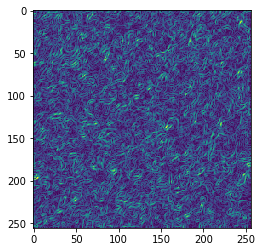

In [18]:
x , y = odp_test(1)
print(x.shape , y.shape)
plt.imshow(x[0,:,:,0])

In [19]:
def arch_maker(x,n_conv,n_class):

    print("\033[91m ============================= Begin ========================= \033[0m")
    
    for _ in range(4):

        
        x = tf.layers.conv2d(x,filters=4,kernel_size=5,
                              strides=(1, 1),padding='same' , trainable=1)
        print(x)
        x = tf.layers.batch_normalization(x, trainable=1)
        print(x)
        x = tf.nn.crelu(x)
        print(x)

    for _ in range(n_conv-2):

        x = tf.layers.conv2d(x,filters=8,kernel_size=5,
                              strides=(1, 1),padding='same', trainable=1)
        print(x)
        x = tf.layers.batch_normalization(x, trainable=1)
        print(x)
        x = tf.nn.crelu(x)
        print(x)
        x = tf.layers.max_pooling2d(x,pool_size=2,strides=1)
        print(x)

        x = tf.layers.conv2d(x,filters=16,kernel_size=5,
                              strides=(2, 2),padding='same', trainable=1)
        print(x)
        x = tf.layers.batch_normalization(x, trainable=1)
        print(x)
        x = tf.nn.crelu(x)
        print(x)
        x = tf.layers.max_pooling2d(x,pool_size=2,strides=1)
        print(x)


    for _ in range(2):

        x = tf.layers.conv2d(x,filters=8,kernel_size=5,
                              strides=(1, 1),padding='same')
        print(x)
        x = tf.layers.batch_normalization(x)
        print(x)
        x = tf.nn.crelu(x)
        print(x)
        x = tf.layers.max_pooling2d(x,pool_size=2,strides=1)
        print(x)

        x = tf.layers.conv2d(x,filters=16,kernel_size=5,
                              strides=(2, 2),padding='same')
        print(x)
        x = tf.layers.batch_normalization(x)
        print(x)
        x = tf.nn.crelu(x)
        print(x)
        x = tf.layers.max_pooling2d(x,pool_size=2,strides=1)
        print(x)


    x = tf.contrib.layers.flatten(x)
    print(x)
    x = tf.nn.dropout( x, keep_prob=0.5)
    print(x)
    x = tf.layers.dense(x, 40 , activation=tf.nn.elu)
    print(x)
    x = tf.nn.dropout( x, keep_prob=0.5)
    print(x)
    x = tf.layers.dense(x, 20 , activation=tf.nn.elu)
    print(x)
    x = tf.nn.dropout( x, keep_prob=0.5)
    print(x)
    y = tf.layers.dense(x, n_class, activation=tf.nn.softmax)
    print(y)

    print("\033[91m ============================ END ============================= \033[0m")

    return y

In [20]:
restore = os.path.isdir('./models/model_noisy_E2E')
restore = 1

In [21]:
def arch(x):
    return arch_maker(x,6,n_class)    

In [22]:
def loss(y_true,x_out):
    return tf.losses.huber_loss(y_true,x_out)  

In [24]:
conv = ng.Model(data_provider= odp_test,
                 optimizer=tf.train.AdamOptimizer,
                 loss = loss,
                 restore=restore,
                 model_add= './models/model_noisy_E2E',
                 arch=arch)

 ============================= Begin ========================= 
Tensor("conv2d/BiasAdd:0", shape=(?, 256, 256, 4), dtype=float32)
Tensor("batch_normalization/FusedBatchNorm:0", shape=(?, 256, 256, 4), dtype=float32)
Tensor("CRelu/Relu:0", shape=(?, 256, 256, 8), dtype=float32)
Tensor("conv2d_1/BiasAdd:0", shape=(?, 256, 256, 4), dtype=float32)
Tensor("batch_normalization_1/FusedBatchNorm:0", shape=(?, 256, 256, 4), dtype=float32)
Tensor("CRelu_1/Relu:0", shape=(?, 256, 256, 8), dtype=float32)
Tensor("conv2d_2/BiasAdd:0", shape=(?, 256, 256, 4), dtype=float32)
Tensor("batch_normalization_2/FusedBatchNorm:0", shape=(?, 256, 256, 4), dtype=float32)
Tensor("CRelu_2/Relu:0", shape=(?, 256, 256, 8), dtype=float32)
Tensor("conv2d_3/BiasAdd:0", shape=(?, 256, 256, 4), dtype=float32)
Tensor("batch_normalization_3/FusedBatchNorm:0", shape=(?, 256, 256, 4), dtype=float32)
Tensor("CRelu_3/Relu:0", shape=(?, 256, 256, 8), dtype=float32)
Tensor("conv2d_4/BiasAdd:0", shape=(?, 256, 256, 8), dtype=flo

/home/bahareh/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


 Model is restored! 


In [26]:
# conv.train(data_provider=odp,training_epochs=100000, 
#             iterations=60, n_s=100,
#             learning_rate = 0.00005 ,  verbose=1 , time_limit = 10)

# Y_t  = [] 
# pr_t = []

# for _ in range(500):
    
#     x, y = odp_test(1)
#     pred = conv.predict(x)
#     Y_t.append(np.argmax(y))
#     pr_t.append(np.argmax(pred))

# conf_plotter(Y_t , pr_t , labels , normalize=1, cmap = plt.cm.RdPu ,mode='test', save=0 , name='overlapping_test.jpg')

# Correction of labels:

String simulated maps are delta(T)/T . CMB simulations are just delta(T)...
So we have to divide gaussian maps to T (ie. Sky temperature which is 2.7 kelvin)
We could do this in our data provider but there is no difference whether we divide Gaussian map to T or divide gmu value to it because at the end we multiply G maps by the gmu. So : 

In [25]:
gmus_ = [gmus[i]/2.7 for i in range(n_class)]
print(gmus_)   
labels = []
for gmu in gmus_:
    labels.append('{:3.1e}'.format(gmu)) 

[0.0, 1.8518518518518515e-08, 3.9896938704294115e-08, 8.595534877060707e-08, 1.8518518518518516e-07, 3.989693870429411e-07, 8.595534877060689e-07, 1.8518518518518517e-06, 3.989693870429411e-06, 8.59553487706069e-06, 1.8518518518518518e-05]


In [27]:
def get_slice_seq(data,nx,ny):
    cp = []
    for i in range(8):
        for j in range(8):          
            cp.append(data[i*nx:(i+1)*nx , j*ny:(j+1)*ny])
            # print(i , ',' , j , ',' , np.array(data[i*nx:(i+1)*nx , j*ny:(j+1)*ny]).shape)
    cp = np.array(cp)
    return cp

In [28]:
class non_overlap_dp(object):
    def __init__(self,n_files,s_files,gmus,s2n,
                 nx=0,ny=0,n_buffer=10,
                 reload_rate=100,filt=None , test=0 , noisy=1):

        self.n_files = n_files
        self.s_files = s_files
        self.test = test
        self.noisy = noisy
        self.s2n = s2n

        nmin = min(len(n_files),len(s_files))
        if n_buffer>= nmin:
            n_buffer = nmin
            self.reload_rate = 0
        else:
            self.reload_rate = reload_rate

        self.nx,self.ny = nx,ny
        self.n_buffer = n_buffer
        self.gmus = gmus
        if filt is None:
            def filt(x):
                return x
        self.filt = filt
        self.counter = 0
        self.reload()

    def reload(self):
        print('Data provider is reloading...')
        self.n_set = []
        self.s_set = []
    #        self.d_set = []
        nind = np.random.randint(0,len(self.n_files))
        
        if self.test:
            sind = (nind%12)
        else:

            sind = np.random.randint(1,3)
            if sind==1:
                sind = (nind%12)
            elif sind==2:
                sind = (nind%12)+12
            
        for i in range(self.n_buffer):
            filen = self.n_files[nind]
            files = self.s_files[sind]
            self.n_set.append(np.load(filen))
            signal = np.load(files)
            self.s_set.append(signal)

    def get_data(self): 
        self.counter += 1
        if self.reload_rate:
            if self.counter%self.reload_rate==0: 
                self.reload() 
    #        n = choice(self.n_set)
        ind = choice(np.arange(self.n_buffer))
        s = self.s_set[ind]
        n = self.n_set[ind]

        return n,s

    
    def pre_process(self, n, s, gmu):
        
        sn = []
                    
        sky = n/0.000109704*1.5e-6 + gmu*(s/12)
        sky = self.filt(sky)
        snslice = get_slice_seq(sky,self.nx,self.ny)
        # print(snslice.shape)
        for i in range(len(snslice)):                    
            sn1 = snslice[i]
            sn1 = (sn1 - np.mean(sn1))/(np.std(sn1) + 1e-30)
            # print(sn1.shape)
            sn.append(sn1[:,:])

        sn = np.array(sn)
#         print(sn.shape)
            
        sn = np.expand_dims(sn,-1)

        return sn#,d

    def __call__(self, n, gmus=None): 

        if gmus is None:
            gmus = self.gmus
        n_class = len(gmus)
        #        x,y = self.get_data()
        X = []
        Y = []
        for i in range(n):                
            n,s = self.get_data()
            # print(n.shape)
            inds = np.arange(n_class)
            shuffle(inds)
            gmu = gmus[inds[0]]
            #            gmu = choice(gmus)
            sn  = self.pre_process(n,s,gmu)
            #            rand = np.random.randint(0,2)
            #            sn = sn-sn+rand

#             sn = (sn - np.min(sn))/(np.max(sn) - np.min(sn))

            #            Y.append(-np.log10(gmu+1e-30))

            lbl = n_class*[0]
            lbl[inds[0]] = 1
            Y.append(lbl)
            X.append(sn)

        X = np.array(X)
        Y = np.array(Y)

        return X,Y

In [30]:
nodp_test = non_overlap_dp(g_test,s_test,
                            gmus=gmus2,
                            s2n = 10,
                            nx=256,ny=256,n_buffer=10,
                            reload_rate=1e5,filt=filt,test=1 , noisy=0)

Data provider is reloading...


(1, 64, 256, 256, 1) (1, 11)


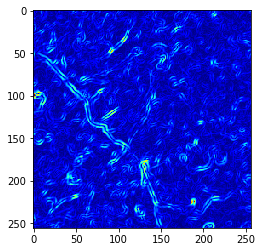

In [31]:
x,y=nodp_test(1)
print(x.shape , y.shape)
plt.imshow(x[0,0,:,:,0] , 'jet')

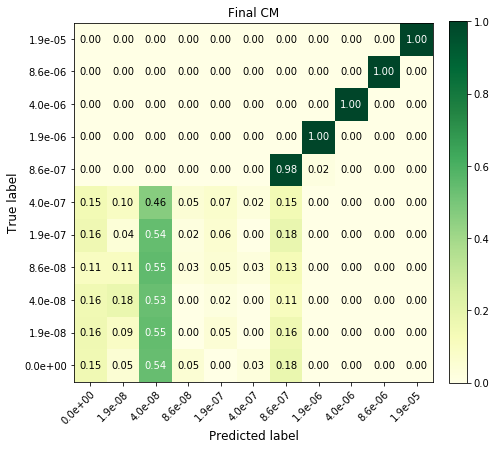

In [31]:
Y_t  = [] 
pr_t = []

for _ in range(500):
    
    x, y = nodp_test(1)
    pred = []
    
    for i in range(6):
        pred.append(conv.predict(x[:,i,:,:,:]))
#     print(np.array(pred).shape)  

    preds = np.prod(np.vstack(pred), axis=0)
    preds = preds/(sum(preds)+1e-30)
#     print(preds)    

        
    Y_t.append(np.argmax(y))
    pr_t.append(np.argmax(preds))



conf_plotter(Y_t , pr_t , labels , normalize=1, cmap = plt.cm.YlGn ,
             title ='Final CM', save=1 , name='finalInshala...7.png')

Normalized confusion matrix


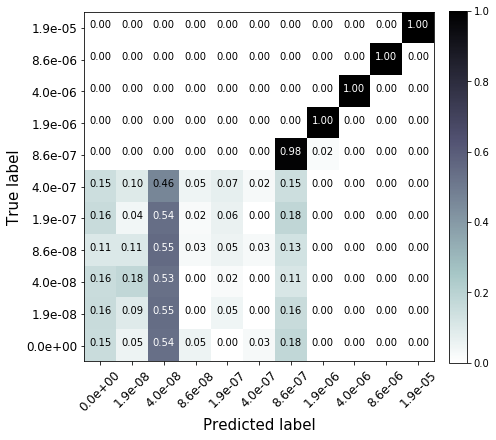

In [33]:
cnf_matrix = confusion_matrix(Y_t,pr_t)
np.set_printoptions(precision=2)

plt.figure(figsize=(7,7))
foo = plot_confusion_matrix(cnf_matrix, labels,normalize=True
                      ,cmap = plt.cm.bone_r)
plt.savefig('./6cross.png')

In [34]:
Xs = {
'x0' : [],
'x1' : [],
'x2' : [],
'x3' : [],
'x4' : [],
'x5' : [],
'x6' : [],
'x7' : [],
'x8' : [],
'x9' : [],
'x10' : []
}


for i in range(500):

    x , y = nodp_test(1)

    pred = []
    for i in range(6):
        pred.append(conv.predict(x[:,i,:,:,:]))
    preds = np.prod(np.vstack(pred), axis=0)
    preds = preds/(sum(preds))

    b = 'x{}'.format(np.argmax(y))
    
    (Xs[b]).append( float(np.dot(preds , gmus3)) ) 
# Xs
print(len(Xs['x0']), len(Xs['x1']),len(Xs['x2']),len(Xs['x3']),len(Xs['x4']))

from scipy.stats import ttest_ind

dist_0 = Xs['x0']
pv_d = [1]

for i in range(1,n_class):
    dist = Xs['x{}'.format(i)]
    tt , pval = ttest_ind(dist , dist_0 )
    pv_d.append(pval)
    
    if pval<= 0.05:
        print('{:3.2e}'.format(gmus3[i]) , ':' , pval)
print('pv_det:' , pv_d)


from scipy.interpolate import interp1d

f = interp1d(pv_d[:7],gmus3[:7], kind='linear')
pv_det = f(0.05)
print('pv_det:' , pv_det)


48 43 34 39 46
8.60e-07 : 3.8020382995201397e-25
1.85e-06 : 5.714200364951404e-122
3.99e-06 : 2.056871669497194e-180
8.60e-06 : 2.2772651013977053e-202
1.85e-05 : 1.9805147560226546e-228
pv_det: [1, 0.1568529026038656, 0.46645325199991683, 0.9436242944377236, 0.2474117496109523, 0.9696444185206504, 3.8020382995201397e-25, 5.714200364951404e-122, 2.056871669497194e-180, 2.2772651013977053e-202, 1.9805147560226546e-228]
pv_det: 5.914567693075587e-07


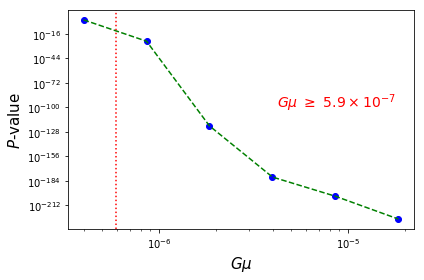

In [54]:
# pv = [ 1, 0.55 , 0.94 , 0.72 , 0.3 , 0.21 , 0.010410934502571674 , 2.132286227637258e-70 , 1.715663208428416e-272 , 0 ,0]
# gmus2[1]=0
# # gmus2[7]=0

plt.axes(xscale='log' , yscale='log')
plt.xlabel('$G\mu$' ,   fontsize=15)
plt.ylabel('$\it{P}$-value' , fontsize=15)
plt.plot(gmus3[5:] , pv_d[5:] , 'bo' , gmus3[5:] , pv_d[5:] , 'g--')
plt.axvline(5.9e-7, color='red', ls=':')#, label='$\it{P}$-value = 0.05' )
# plt.text(1e-7 , 0.02 , '$\it{P}&-value = 0.05' , color='red')
# plt.plot(3.7e-7 , 0.05 , 'o' , markersize=8 , color='r')
plt.text(4.2e-6, 1e-100 ,r'$G\mu$ $\geq$ $5.9\times 10^{-7}$' , color='r' ,fontsize=14)
# plt.title('Noisy E2E: P-value $min_{det}$')
# plt.xlim([2e-8,5e-7])
# plt.legend()
plt.tight_layout()
plt.savefig('pv_6cross.png')
plt.savefig('pv_6cross.pdf')

# plt.savefig('moreMax_pv_det.pdf')

In [193]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          #title='Confusion matrix',
                          cmap=plt.cm.Purples):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.gca().invert_yaxis()

    #plt.title(title,fontsize = 15)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45 , fontsize=9)
    plt.yticks(tick_marks, classes , fontsize=9)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range((cm.shape[0])):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label',fontsize = 13)
    plt.xlabel('Predicted label',fontsize = 13)
    plt.tight_layout()



noisy E2E simulations are the most similar maps to Plank18 observations. So we can apply the trained model on obsevations to see the prediction of machine on them...

In [32]:
from ccgpack import filters


def masking(path_obs , mask_per , obs_name ,path_mask=1):
    
    if os.path.exists('ind_'+str(mask_per)+'_256.npy') == 1:
        ind = np.load('ind_'+str(mask_per)+'_256.npy')
        print('inds are restored!')
   
    else:
        print('zeki :)') 
        ind = []
        for i in range(768):
            patch = np.load(str(path_mask)+str(i)+'.npy')
            if np.mean(patch) >= mask_per:
                ind.append(i)
        np.save('ind_'+str(mask_per) , ind )
        
    print(len(ind)/768*100 , '% patches remained')
    
    keys = []
    
    if obs_name in ['sevem_dr3','cr_dr3','nilc_dr3','smica_dr3_' , ''] :

        for i_patch in range(12*64):
            if i_patch in ind:
                key = '{}{}'.format(obs_name,i_patch)
                keys.append(key)
                    
    elif obs_name == 'null_ffp':
                
        keys = []

        for i_patch in range(12*64):
            if i_patch in ind:
                key = '{}'.format(i_patch)
                keys.append(key)
                
        
    elif obs_name == 'string_ffp':
                
        keys = []

        i_gmu = 5 
        for i_patch in range(12*64):
            if i_patch in ind:
                key = '{}_{}'.format(i_gmu,i_patch)
                keys.append(key)
                
    if (len(keys) != len(ind)):
        print('something is wrong')
      
        
    cmb = []
    
    for key in keys:
        cmb.append(str(path_obs) +key+'.npy')           
                
    if len(cmb)==0:
        print('Somthing is wrong with initiation.')
#         exit()
    
    c_ps = []

    for c in cmb:
        cp = np.load(c)
        cp = filters(filters(cp ,edd_method='sch') , 'sob')

        # cp = cv.bilateralFilter(cp,5,1e-3,1e-3)

        # cp = (cp - np.min(cp))/(np.max(cp) - np.min(cp))
        cp = ( cp - np.mean(cp))/(np.std(cp)+1e-30)
        
        c_ps.append(cp)

    c_ps = np.array(c_ps)
    c_ps = np.expand_dims(c_ps , -1)

    
    print('c_ps shape : ' , c_ps.shape)
    
    return c_ps
    

In [33]:
sm = masking( path_obs='./data/observations_p/observations_p/' , mask_per=0.95 , obs_name='smica_dr3_')

inds are restored!
63.671875 % patches remained
c_ps shape :  (489, 256, 256, 1)


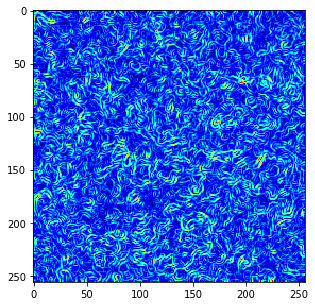

In [34]:
plt.figure(figsize = (5,5))
plt.imshow(sm[20,:,:,0] , cmap='jet')

In [33]:
# from shapely.geometry.polygon import Polygon
pr = []
di_pr = []
# for i in sm:
#     i = i.reshape(1, 256 , 256,1)
#     pred = conv.predict(i)
#     pr.append(np.argmax(pred))

for i in range(len(sm)-5):
    
    if i%6 == 0:
        
        pred = []
    
        for j in range(6):
            
            sm_p = sm[i+j].reshape(1, 256 , 256,1)
            pred.append(conv.predict(sm_p))

        preds = np.prod(np.vstack(pred), axis=0)
        preds = preds/(sum(preds)+1e-30)
        print(preds)

        pr.append(np.argmax(preds))
        di_pr.append(np.dot(preds , gmus3))


    else:
        continue 
    


[1.1419377e-01 1.0715133e-01 1.4317952e-01 8.8536173e-02 1.1204524e-01
 1.3753362e-01 2.9736039e-01 5.5642265e-11 1.5590711e-21 2.8233200e-18
 8.7592524e-15]
[1.55243278e-01 1.56518966e-01 1.54050544e-01 1.44966096e-01
 1.42866209e-01 1.42012984e-01 1.04341954e-01 2.68289613e-09
 4.87878738e-15 2.51716953e-10 3.42512380e-10]
[1.6667628e-01 1.6867457e-01 1.5608706e-01 1.3360810e-01 1.3957873e-01
 1.4049995e-01 9.4875276e-02 5.2475260e-13 1.6920907e-19 2.3994915e-13
 3.2037686e-12]
[1.90200079e-02 1.64658632e-02 2.07899511e-02 1.05533581e-02
 2.06885673e-02 2.35335846e-02 8.87655675e-01 1.29295595e-03
 9.32026086e-18 1.09697028e-17 1.27857525e-11]
[4.7604267e-02 4.9064908e-02 5.1454000e-02 3.9316934e-02 5.3069524e-02
 6.2549792e-02 6.9694054e-01 1.8488742e-09 7.6629223e-24 3.4375966e-22
 1.9530886e-15]
[1.3850848e-01 1.3308471e-01 1.5209195e-01 9.5258042e-02 1.5532032e-01
 1.4221093e-01 1.8352552e-01 3.5424327e-11 4.0839203e-21 6.4720628e-16
 6.9222704e-13]
[2.4367848e-03 2.7248194e-03 2

[1.24492571e-02 9.88628995e-03 1.15480693e-02 6.61677588e-03
 1.38306553e-02 1.62533224e-02 8.17392588e-01 1.12023056e-01
 1.06632586e-15 5.06860380e-18 1.23623778e-12]
[4.7772277e-02 4.2676784e-02 4.2093735e-02 2.7625566e-02 4.1656919e-02
 5.4043036e-02 7.4413097e-01 7.0264315e-07 1.6757182e-17 2.8152394e-17
 9.0172904e-12]
[1.02231249e-01 9.26930681e-02 1.21867612e-01 6.70109466e-02
 1.14923075e-01 1.18086308e-01 3.83187711e-01 4.21406821e-09
 1.19823461e-20 8.02905707e-17 1.53374641e-13]
[2.1310993e-07 1.8758408e-07 1.5479996e-07 1.3492176e-07 2.7917105e-07
 2.3183151e-07 4.2574407e-05 9.9995619e-01 2.3965658e-11 3.1443309e-17
 1.4461795e-09]
[6.9001284e-16 4.1178949e-16 4.1355240e-16 1.5420670e-16 1.1104685e-15
 1.2221046e-15 5.0448801e-10 1.0000000e+00 2.2627570e-25 1.1065353e-40
 2.6102117e-22]
[7.3527884e-27 3.6224597e-27 3.0574577e-27 1.3198576e-27 1.5866626e-26
 1.3282861e-26 1.1893752e-19 1.0000000e+00 8.2665989e-24 0.0000000e+00
 2.1351076e-20]
[1.6050585e-01 1.4596120e-01 1

In [37]:
pv_obs = []
for i in range(n_class):
    tt , pvl = ttest_ind( Xs['x{}'.format(i)] , di_pr)
    pv_obs.append(pvl)
    print(i ,':' , pvl)
print('the most similar class:' , np.argmax(pv_obs))
#     if pvl[0] <= 0.05:
#         print(gmus2[i])

0 : 7.250504496568587e-09
1 : 6.44888005684224e-07
2 : 8.688630628429077e-07
3 : 2.5165650710955625e-07
4 : 1.111218989167772e-07
5 : 7.852219584228848e-07
6 : 8.268624940336224e-10
7 : 1.2910613710908206e-09
8 : 8.320159784054887e-54
9 : 5.165879809999848e-100
10 : 5.8956929335955765e-149
the most similar class: 2


In [ ]:
plt.xscale('log')
# plt.yscale('log')
plt.plot(gmus2 , pv_obs , 'o')
# plt.axhline(0.05 , 'r')